In [19]:
import os
import pickle
from tabulate import tabulate

os.environ['OMP_NUM_THREADS'] = '4'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openai
openai.api_key = os.environ['OPENAI_API_KEY']
openai.api_base = os.environ.get("OPENAI_API_BASE", "https://api.openai.com/v1")
from data.serialize import SerializerSettings
from models.utils import grid_iter
from models.promptcast import get_promptcast_predictions_data
from models.darts import get_arima_predictions_data
from models.llmtime import get_llmtime_predictions_data
from data.small_context import get_datasets
from data.small_context import get_bitcoin_datasets
from data.small_context import get_bitcoin_datasets_hourly

from models.validation_likelihood_tuning import get_autotuned_predictions_data

%load_ext autoreload
%autoreload 2

def plot_preds(train, test, pred_dict, model_name, show_samples=False, save_index = 0):
    save_folder = "./plot/" + str(save_index)
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(train)
    plt.plot(test, label='Truth', color='black')
    plt.plot(pred, label=model_name, color='purple')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(pred.index, lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(pred.index, samples[i], color='purple', alpha=0.3, linewidth=1)
    plt.legend(loc='upper left')
    if 'NLL/D' in pred_dict:
        nll = pred_dict['NLL/D']
        if nll is not None:
            plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    plt.savefig(save_folder)
    plt.show()


def plot_preds_candles(df, train, test, pred_dict, model_name, show_samples=False, save_index = 0):

    save_folder = "./plot/" + str(save_index)
    pred = pred_dict['median']
    pred = pd.Series(pred)
    index = len(train)

    opens = pd.Series(df['open'].values, index=df['date'])
    truth = pd.Series(df['close'].values, index=df['date'])
    highs = pd.Series(df['high'].values, index=df['date'])
    lows = pd.Series(df['low'].values, index=df['date'])

    plt.figure(figsize=(8, 6), dpi=100)

    ## Draw candles
    height = truth - opens
    bottom = np.where(height > 0, opens, truth + abs(height))
    color = np.where(height > 0, 'g', 'r')

    plt.bar(range(len(truth)), height, bottom=bottom, color=color, align='center')
    plt.vlines(range(len(highs)), ymin=lows, ymax=highs, color=color, linewidth=1)            

    plt.plot(range(index, index + len(pred)), pred, label=model_name, color='purple')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(range(index, index + len(pred)), lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(range(index, index + len(pred)), samples[i], color='purple', alpha=0.3, linewidth=1)
    plt.legend(loc='upper left')
    if 'NLL/D' in pred_dict:
        nll = pred_dict['NLL/D']
        if nll is not None:
            plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

    index_to_display = range(0, len(truth), len(truth) // 6)
    truth.index = truth.index.date
    display_date = truth.index[index_to_display]
    plt.xticks(index_to_display, display_date)

    # plt.xticks(range(len(truth)), truth.index)
    # plt.grid()

    plt.savefig(save_folder)
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define models ##

In [13]:
gpt4_hypers = dict(
    alpha=0.3,
    basic=True,
    temp=1.0,
    top_p=0.8,
    settings=SerializerSettings(base=10, prec=3, signed=True, time_sep=', ', bit_sep='', minus_sign='-')
)

gpt3_hypers = dict(
    temp=0.7,
    alpha=0.95,
    beta=0.3,
    basic=False,
    settings=SerializerSettings(base=10, prec=3, signed=True, half_bin_correction=True)
)


promptcast_hypers = dict(
    temp=0.7,
    settings=SerializerSettings(base=10, prec=0, signed=True, 
                                time_sep=', ',
                                bit_sep='',
                                plus_sign='',
                                minus_sign='-',
                                half_bin_correction=False,
                                decimal_point='')
)

arima_hypers = dict(p=[12,30], d=[1,2], q=[0])

model_hypers = {
    'LLMTime GPT-3.5': {'model': 'gpt-3.5-turbo-instruct', **gpt3_hypers},
    'LLMTime GPT-4': {'model': 'gpt-4', **gpt4_hypers},
    # 'LLMTime GPT-3': {'model': 'text-davinci-004', **gpt3_hypers},
    # 'PromptCast GPT-3': {'model': 'text-davinci-004', **promptcast_hypers},
    # 'ARIMA': arima_hypers,
    
}

model_predict_fns = {
    # 'LLMTime GPT-3.5': get_llmtime_predictions_data,
    # 'LLMTime GPT-3': get_llmtime_predictions_data,
    'LLMTime GPT-4': get_llmtime_predictions_data,
    # 'PromptCast GPT-3': get_promptcast_predictions_data,
    # 'ARIMA': get_arima_predictions_data,
}

model_names = list(model_predict_fns.keys())

In [4]:
starting_date = '2023-11-01'
index = 0
for predict_step in [3,5,7] :

    with open(f"datasets/bitcoin/BTC_BitHourly.csv") as f:
        df = pd.read_csv(f, usecols=[0, 5], parse_dates=[0])
        mask = (df["timestamp"] > starting_date) 
        df = df.loc[mask]

        start_date = df["timestamp"].iloc[0]
        end_date = df["timestamp"].iloc[-1]

        print("Data set : BTC_Daily_ohlc")
        print(f"from {start_date} to {end_date}")
        print(f"{df.shape[0]} data points, training on {df.shape[0]- predict_step} and forecasting on {predict_step} points")
        print("Imput is scaled closing price")

    datasets = get_bitcoin_datasets_hourly(predict_steps=predict_step, timestamp="2023-11-01")
    ds_name = 'BTC_BitHourly'


    data = datasets[ds_name]
    train, test = data # or change to your own data
    print(train)

Data set : BTC_Daily_ohlc
from 2023-11-01 01:00:00 to 2023-11-29 10:00:00
682 data points, training on 610 and forecasting on 72 points
Imput is scaled closing price
timestamp
2023-11-01 01:00:00    34439.0
2023-11-01 02:00:00    34392.0
2023-11-01 03:00:00    34487.0
2023-11-01 04:00:00    34553.0
2023-11-01 05:00:00    34652.0
                        ...   
2023-11-26 06:00:00    37823.0
2023-11-26 07:00:00    37757.0
2023-11-26 08:00:00    37809.0
2023-11-26 09:00:00    37764.0
2023-11-26 10:00:00    37710.0
Length: 610, dtype: float64
Data set : BTC_Daily_ohlc
from 2023-11-01 01:00:00 to 2023-11-29 10:00:00
682 data points, training on 562 and forecasting on 120 points
Imput is scaled closing price
timestamp
2023-11-01 01:00:00    34439.0
2023-11-01 02:00:00    34392.0
2023-11-01 03:00:00    34487.0
2023-11-01 04:00:00    34553.0
2023-11-01 05:00:00    34652.0
                        ...   
2023-11-24 06:00:00    37257.0
2023-11-24 07:00:00    37309.0
2023-11-24 08:00:00    37301.0

Data set : BTC_Daily_ohlc
from 2023-10-19 to 2023-01-01
training on 6 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.70s/it]

targets [34496.13543162 34152.32274009 33892.87040305 34081.43780445
 34526.42138452 34475.78238345 34640.73874548]
median date
2023-10-25 09:00:00    34690.594917
2023-10-26 09:00:00    34943.810938
2023-10-27 09:00:00    37788.767413
2023-10-28 09:00:00    38414.359936
2023-10-29 09:00:00    38905.896918
2023-10-30 09:00:00    38905.896918
2023-10-31 09:00:00    38905.896918
dtype: float64
Raw list completion :
[['1166, 1174, 1278, 1306', '1162, 1164, 1268, 1296, 1320, 1322', '1162, 1164, 1268, 1296, 1320, 1322', '1170, 1195, 1230, 1250, 1280', '1166, 1168, 1272, 1300, 1328, 1330, 1434', '1167, 1176, 1178, 1282, 1310', '1160, 1164, 1268, 1296', '1166, 1184, 1201, 1220', '1162, 1171, 1173, 1277, 1305', '1142, 1246, 1274, 1278']]
Model :  LLMTime GPT-4
MAE :  3184.2164379947885
MAES :  13087684.392711189
dic_error_median :  {'input_length': {6: {'Mae': 3184.2164379947885, 'Mse': 13087684.392711189}, 12: {'Mae': None, 'Mse': None}, 24: {'Mae': None, 'Mse': None}, 48: {'Mae': None, 'Mse'

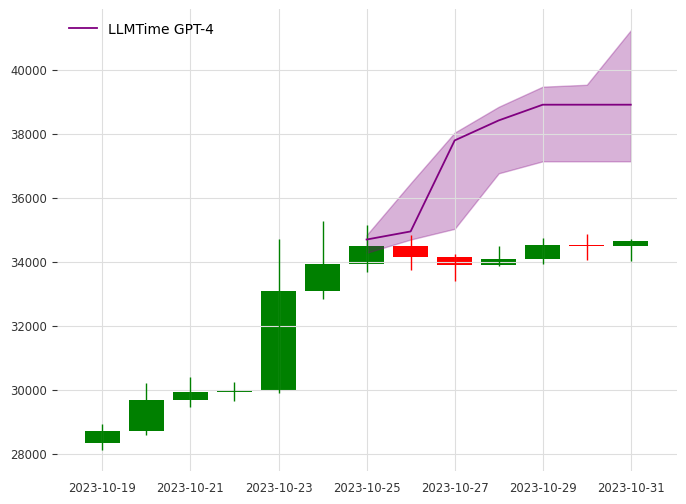

Data set : BTC_Daily_ohlc
from 2023-10-13 to 2023-01-01
training on 12 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]

targets [34496.13543162 34152.32274009 33892.87040305 34081.43780445
 34526.42138452 34475.78238345 34640.73874548]
median date
2023-10-25 09:00:00    33997.640273
2023-10-26 09:00:00    34394.444745
2023-10-27 09:00:00    35754.917219
2023-10-28 09:00:00    36406.810280
2023-10-29 09:00:00    37781.454343
2023-10-30 09:00:00    38107.400873
2023-10-31 09:00:00    39439.530171
dtype: float64
Raw list completion :
[['1197, 1200, 1306, 1336, 1337, 1340, 1446, ', '1196, 1221, 1249, 1272, 1300, 1326, 1349, ', '1215, 1252, 1300, 1346, 1390, 1441, 1493', '1223, 1245, 1268, 1296, 1328, 1353, 1383, ', '1197, 1199, 1215, 1246, 1256, 1260, 1368, ', '1196, 1205, 1231, 1254, 1254, 1257, 1365, ', '1222, 1255, 1285, 1310, 1340, 1366, 1399, ', '1198, 1190, 1209, 1254, 1263, 1282', '1200, 1203, 1305, 1336, 1344, 1348, 1453, ', '1217, 1250, 1254, 1257, 1355, 1381, 1410']]
Model :  LLMTime GPT-4
MAE :  2373.3541898942835
MAES :  7999141.078329499
dic_error_median :  {'input_length': {6: {'Mae': 3184.216

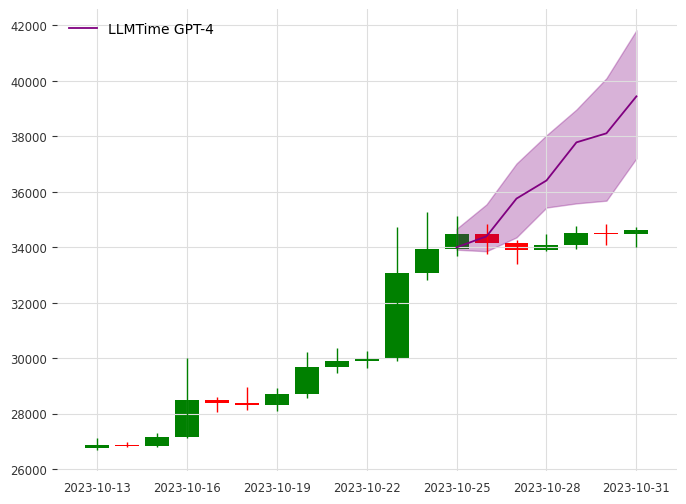

Data set : BTC_Daily_ohlc
from 2023-10-01 to 2023-01-01
training on 24 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

targets [34496.13543162 34152.32274009 33892.87040305 34081.43780445
 34526.42138452 34475.78238345 34640.73874548]
median date
2023-10-25 09:00:00    34473.496588
2023-10-26 09:00:00    35145.414382
2023-10-27 09:00:00    35940.745647
2023-10-28 09:00:00    36598.950833
2023-10-29 09:00:00    37531.408179
2023-10-30 09:00:00    38134.762932
2023-10-31 09:00:00    39588.299383
dtype: float64
Raw list completion :
[['1245, 1252, 1300, 1325, 1336, 1339, 1405, 143', '1275, 1318, 1370, 1433, 1506, 1580, 1665, 175', '1248, 1261, 1277, 1292, 1307, 1323, 1339, 135', '1239, 1244, 1277, 1301, 1317, 1320, 1420, 145', '1257, 1295, 1330, 1368, 1407, 1446, 1483, 152', '1256, 1267, 1287, 1308, 1331, 1347, 1362, 138', '1267, 1301, 1334, 1367, 1400, 1433, 1466, 150', '1245, 1252, 1258, 1264, 1270, 1276, 1282, 128', '1259, 1304, 1320, 1343, 1475, 1528', '1271, 1316, 1345, 1380, 1434, 1490, 1543, 160']]
Model :  LLMTime GPT-4
MAE :  2456.0923911928185
MAES :  8344978.4205345
dic_error_median :  {'input_

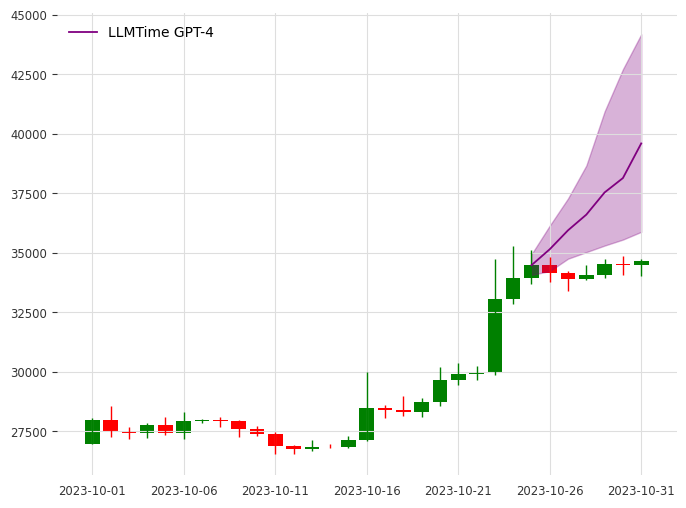

Data set : BTC_Daily_ohlc
from 2023-09-07 to 2023-01-01
training on 48 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

targets [34496.13543162 34152.32274009 33892.87040305 34081.43780445
 34526.42138452 34475.78238345 34640.73874548]
median date
2023-10-25 09:00:00    34247.040821
2023-10-26 09:00:00    34592.433785
2023-10-27 09:00:00    34791.698957
2023-10-28 09:00:00    35336.357092
2023-10-29 09:00:00    35588.759643
2023-10-30 09:00:00    35867.730883
2023-10-31 09:00:00    36159.986468
dtype: float64
Raw list completion :
[['1289, 1301, 1325, 1375, 1380, 1392, 1401, 1407', '1298, 1302, 1303, 1308, 1315, 1310, 1300, 1307', '1278, 1302, 1316, 1340, 1362, 1375, 1388, 1400', '1284, 1291, 1303, 1315, 1330, 1344, 1357, 1368', '1285, 1286, 1295, 1312, 1308, 1287, 1288, 1288', '1307, 1340, 1342, 1370, 1388, 1405, 1423, 1450', '1275, 1287, 1300, 1304, 1310, 1318, 1327, 1336', '1296, 1305, 1314, 1342, 1348, 1355, 1364, 1373', '1300, 1325, 1340, 1360, 1380, 1395, 1410, 1430', '1288, 1291, 1304, 1319, 1330, 1333, 1345, 1350']]
Model :  LLMTime GPT-4
MAE :  973.7839969497093
MAES :  1144665.4129625
dic_erro

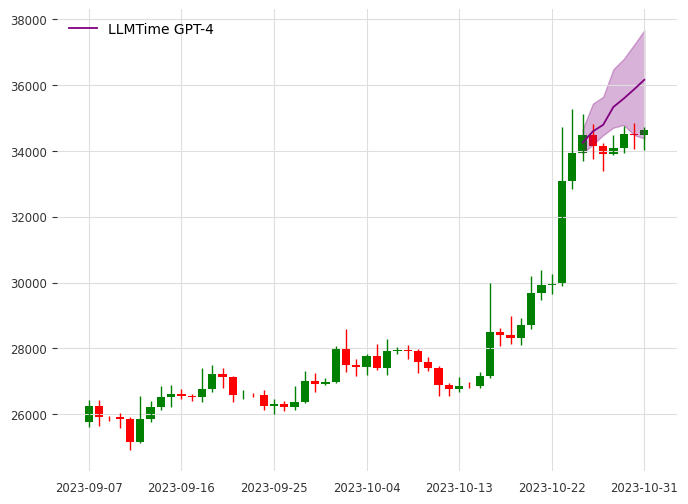

Data set : BTC_Daily_ohlc
from 2023-07-21 to 2023-01-01
training on 96 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

targets [34496.13543162 34152.32274009 33892.87040305 34081.43780445
 34526.42138452 34475.78238345 34640.73874548]
median date
2023-10-25 09:00:00    34037.264783
2023-10-26 09:00:00    34063.742624
2023-10-27 09:00:00    34249.087512
2023-10-28 09:00:00    34619.777288
2023-10-29 09:00:00    34659.494050
2023-10-30 09:00:00    34765.405414
2023-10-31 09:00:00    35056.661667
dtype: float64
Raw list completion :
[['1285, 1288, 1291, 1300, 1305, 1308, 1311, 1318', '1302, 1304, 1347, 1381, 1395, 1401, 1432, 1469', '1285, 1286, 1307, 1329, 1328, 1331, 1350, 1360', '1286, 1284, 1300, 1315, 1323, 1321, 1338, 1345', '1284, 1290, 1295, 1301, 1307, 1313, 1319, 1325', '1284, 1286, 1289, 1291, 1304, 1308, 1312, 1316', '1275, 1264, 1274, 1309, 1299, 1311, 1346, 1378', '1286, 1283, 1279, 1289, 1275, 1283, 1286, 1299', '1283, 1286, 1284, 1305, 1310, 1312, 1314, 1329', '1286, 1295, 1303, 1311, 1316, 1322, 1328, 1334']]
Model :  LLMTime GPT-4
MAE :  325.80371064508137
MAES :  129955.77830199001
dic_

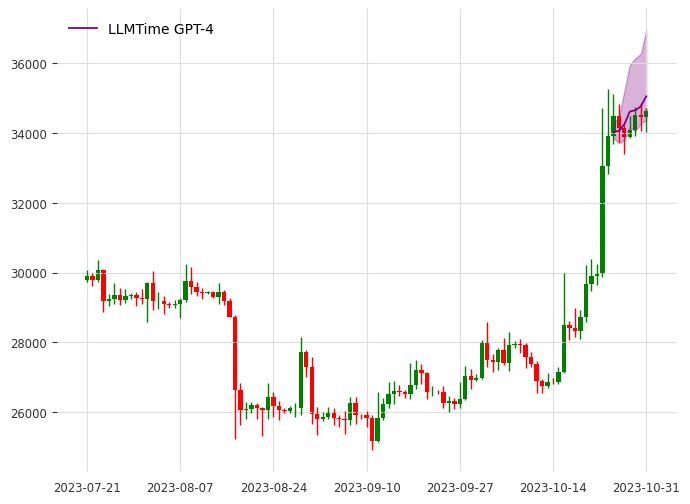

Data set : BTC_Daily_ohlc
from 2023-04-16 to 2023-01-01
training on 192 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


targets [34496.13543162 34152.32274009 33892.87040305 34081.43780445
 34526.42138452 34475.78238345 34640.73874548]
median date
2023-10-25 09:00:00    34253.922254
2023-10-26 09:00:00    34562.153948
2023-10-27 09:00:00    34990.998045
2023-10-28 09:00:00    35098.209070
2023-10-29 09:00:00    35366.236630
2023-10-30 09:00:00    35460.046277
2023-10-31 09:00:00    35741.475215
dtype: float64
Raw list completion :
[['1285, 1306, 1319, 1326, 1341, 1343, 1345, 1347', '1256, 1240, 1213, 1187, 1181, 1207, 1204, 1199', '1317, 1369, 1368, 1373, 1369, 1370, 1372, 1376', '1268, 1262, 1259, 1260, 1255, 1260, 1257, 1255', '1270, 1280, 1298, 1292, 1297, 1302, 1321, 1336', '1253, 1225, 1245, 1237, 1234, 1263, 1268, 1307', '1287, 1311, 1325, 1344, 1367, 1389, 1405, 1422', '1285, 1298, 1312, 1337, 1360, 1384, 1409, 1436', '1230, 1238, 1233, 1232, 1237, 1243, 1239, 1241', '1297, 1329, 1361, 1393, 1425, 1457, 1489, 1521']]
Model :  LLMTime GPT-4
MAE :  813.1084146194532
MAES :  764574.6859048309
dic_er

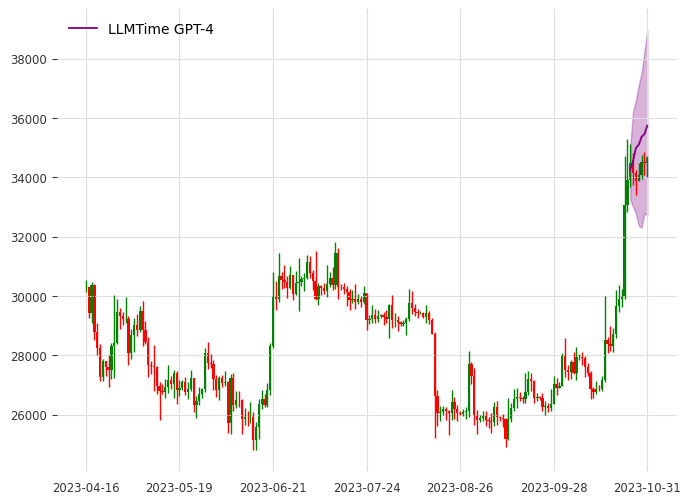

Two pickle files have been created one with MSE/MAE among all samples and the second with MSE/MAE among median only
The path for the pickle file are the following : 
pickle/dic_error_classic_median.pkl


In [17]:
# datasets = get_bitcoin_datasets(predict_steps=30, start_date="2024-02-01")
# ds_name = 'BTC_BitHourly'
starting_date = '2023-11-01'
index = 0

dic_error_median = {"input_length" : {6: {"Mae": None, "Mse": None},
                            12: {"Mae": None, "Mse": None},
                            24: {"Mae": None, "Mse": None},
                            48: {"Mae": None, "Mse": None},
                            96: {"Mae": None, "Mse": None},
                            192: {"Mae": None, "Mse": None}}}

predict_step = 7 
for input_length in [6, 12, 24, 48, 96, 192] :

    train, test, df = get_bitcoin_datasets(input_length, predict_length = predict_step, end_date = "2023-11-01")
    ds_name = 'BTC_Daily_ohlc'

    out = {}

    for i,model in enumerate(model_names): # GPT-4 takes a about a minute to run
        model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
        hypers = list(grid_iter(model_hypers[model]))
        num_samples = 10
        pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)

        targets = np.array(test)
        medians = pred_dict['median']
        print("targets", targets)
        print("median", medians)
        medians = medians.values

        mae = np.mean(np.abs(medians - test)) # (num_series)
        mse = np.mean(np.square(medians - test))
        pred_dict['maes'] = mse
        pred_dict['mae'] = mae

        out[model] = pred_dict

        print("Raw list completion :")
        print(pred_dict["completions_list"])

        print("Model : ", model)
        print("MAE : ", pred_dict['mae'])
        print("MAES : ", pred_dict['maes']) 

        dic_error_median["input_length"][input_length]["Mae"] = pred_dict['mae']
        dic_error_median["input_length"][input_length]["Mse"] = pred_dict['maes']
        print("dic_error_median : ",dic_error_median)


        string = out[model]['input_strs']
        string = str(string)
        number_comma = 0
        for elt in string :
            # print(elt)
            if elt == ',' :
                number_comma += 1
        print("Sequence lenght : ", number_comma - 1)
        print("Raw scaled sequence")
        print(string)

        index += 1
        plot_preds_candles(df ,train, test, pred_dict, model, show_samples=False, save_index=index)
    
    
dic_name_median =  "pickle/dic_error_" + "classic" + "_median" + ".pkl"

with open(dic_name_median, 'wb') as fichier:
    pickle.dump(dic_error_median, fichier)

print("Two pickle files have been created one with MSE/MAE among all samples and the second with MSE/MAE among median only")
print(f"The path for the pickle file are the following : ")
print(dic_name_median)


        


In [20]:
with open("pickle/dic_error_classic_median.pkl", 'rb') as fichier:
        dict_error_median = pickle.load(fichier)


print(dic_error_median)

def display_tab (dic_error_number) :
    table = []
    for key, value in dic_error_number['input_length'].items():
        row = [key, value['Mae'], value['Mse']]
        table.append(row)

    # En-tête du tableau
    headers = ['input_length', 'Mae', 'Mse']

    # Affichage du tableau
    print(tabulate(table, headers=headers))

display_tab(dic_error_median)

{'input_length': {6: {'Mae': 3184.2164379947885, 'Mse': 13087684.392711189}, 12: {'Mae': 2373.3541898942835, 'Mse': 7999141.078329499}, 24: {'Mae': 2456.0923911928185, 'Mse': 8344978.4205345}, 48: {'Mae': 973.7839969497093, 'Mse': 1144665.4129625}, 96: {'Mae': 325.80371064508137, 'Mse': 129955.77830199001}, 192: {'Mae': 813.1084146194532, 'Mse': 764574.6859048309}}}
  input_length       Mae               Mse
--------------  --------  ----------------
             6  3184.22        1.30877e+07
            12  2373.35        7.99914e+06
            24  2456.09        8.34498e+06
            48   973.784       1.14467e+06
            96   325.804  129956
           192   813.108  764575


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:04<00:00,  4.22s/it]


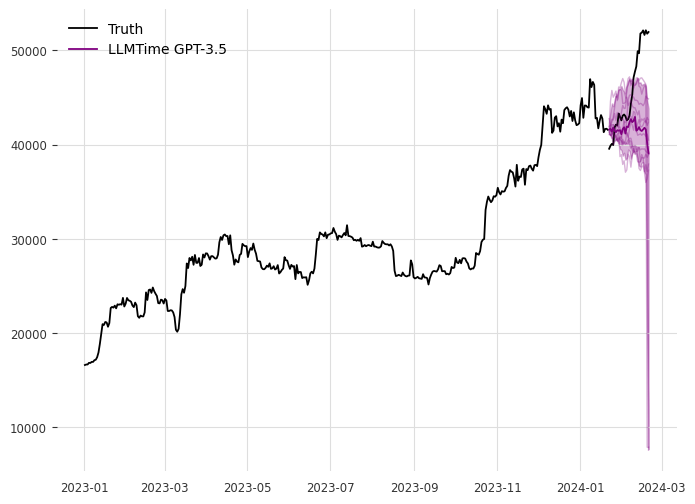

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:05<00:00,  5.18s/it]

<Figure size 640x480 with 0 Axes>

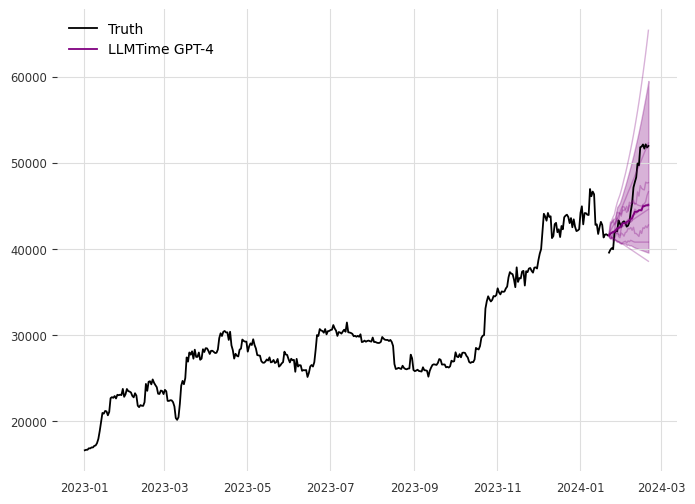

Model :  LLMTime GPT-3.5
Sequence lenght :  386
(' 2 5 2 , 2 5 4 , 2 5 4 , 2 5 9 , 2 5 8 , 2 6 1 , 2 6 1 , 2 6 6 , 2 6 8 , 2 7 5 , 2 8 9 , 3 1 4 , 3 4 4 , 3 7 3 , 3 7 0 , 3 7 9 , 3 7 8 , 3 6 5 , 3 7 6 , 4 2 0 , 4 2 3 , 4 2 1 , 4 2 7 , 4 1 9 , 4 3 1 , 4 3 0 , 4 3 1 , 4 3 0 , 4 5 0 , 4 2 4 , 4 3 3 , 4 5 0 , 4 4 3 , 4 4 1 , 4 3 8 , 4 2 7 , 4 2 3 , 4 3 6 , 4 2 8 , 3 9 6 , 3 9 1 , 3 9 8 , 3 9 6 , 3 9 5 , 4 0 7 , 4 6 6 , 4 4 4 , 4 7 3 , 4 7 5 , 4 6 5 , 4 8 0 , 4 7 0 , 4 6 2 , 4 5 5 , 4 3 4 , 4 3 4 , 4 4 5 , 4 4 3 , 4 3 3 , 4 4 7 , 4 4 2 , 4 1 1 , 4 1 1 , 4 1 4 , 4 1 3 , 4 0 7 , 3 9 3 , 3 5 6 , 3 5 0 , 3 5 9 , 4 0 2 , 4 6 0 , 4 7 6 , 4 6 5 , 4 8 5 , 5 5 1 , 5 3 8 , 5 6 7 , 5 6 0 , 5 7 1 , 5 4 7 , 5 7 6 , 5 5 3 , 5 5 3 , 5 6 7 , 5 4 4 , 5 4 8 , 5 7 8 , 5 6 9 , 5 8 1 , 5 8 1 , 5 7 3 , 5 6 3 , 5 7 3 , 5 7 3 , 5 6 9 , 5 6 6 , 5 6 6 , 5 7 7 , 6 1 4 , 6 2 9 , 6 2 1 , 6 3 4 , 6 3 7 , 6 3 2 , 6 3 2 , 6 0 8 , 6 3 4 , 5 9 0 , 5 7 5 , 5 4 8 , 5 6 3 , 5 5 7 , 5 5 5 , 5 7 6 , 5 8 0 , 6 0 9 , 6 0 5 , 6 0 2

100%|██████████| 1/1 [00:14<00:00, 14.16s/it]

<Figure size 640x480 with 0 Axes>

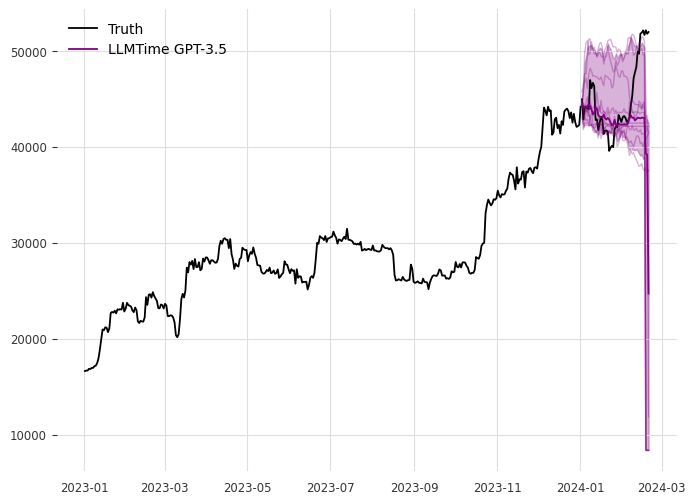

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:09<00:00,  9.30s/it]

<Figure size 640x480 with 0 Axes>

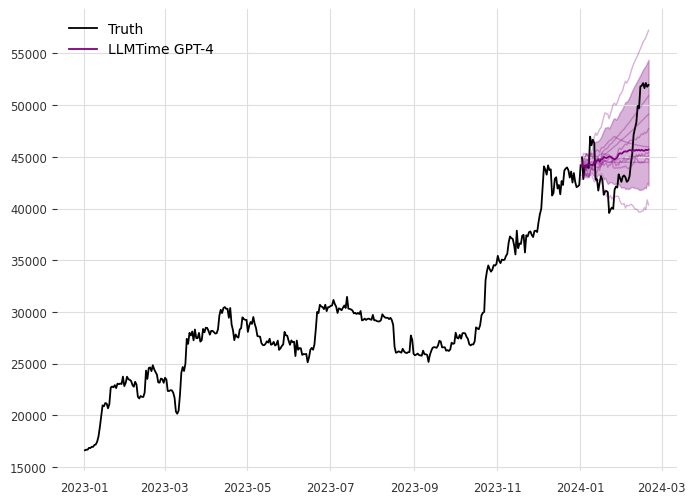

Model :  LLMTime GPT-3.5
Sequence lenght :  366
(' 2 4 2 , 2 4 4 , 2 4 4 , 2 4 9 , 2 4 8 , 2 5 2 , 2 5 2 , 2 5 7 , 2 5 8 , 2 6 6 , 2 8 1 , 3 0 7 , 3 3 9 , 3 6 9 , 3 6 7 , 3 7 6 , 3 7 4 , 3 6 1 , 3 7 3 , 4 1 9 , 4 2 3 , 4 2 1 , 4 2 7 , 4 1 8 , 4 3 1 , 4 2 9 , 4 3 1 , 4 3 0 , 4 5 1 , 4 2 4 , 4 3 3 , 4 5 1 , 4 4 3 , 4 4 2 , 4 3 9 , 4 2 7 , 4 2 2 , 4 3 6 , 4 2 8 , 3 9 4 , 3 8 9 , 3 9 6 , 3 9 3 , 3 9 3 , 4 0 6 , 4 6 8 , 4 4 4 , 4 7 5 , 4 7 7 , 4 6 6 , 4 8 3 , 4 7 2 , 4 6 4 , 4 5 7 , 4 3 5 , 4 3 4 , 4 4 5 , 4 4 4 , 4 3 3 , 4 4 8 , 4 4 3 , 4 1 0 , 4 1 0 , 4 1 2 , 4 1 2 , 4 0 6 , 3 9 1 , 3 5 2 , 3 4 6 , 3 5 5 , 4 0 0 , 4 6 2 , 4 7 8 , 4 6 7 , 4 8 8 , 5 5 8 , 5 4 4 , 5 7 5 , 5 6 7 , 5 7 9 , 5 5 4 , 5 8 4 , 5 6 0 , 5 6 0 , 5 7 5 , 5 5 0 , 5 5 4 , 5 8 6 , 5 7 7 , 5 8 9 , 5 8 9 , 5 8 1 , 5 7 0 , 5 8 1 , 5 8 1 , 5 7 7 , 5 7 3 , 5 7 4 , 5 8 5 , 6 2 4 , 6 4 0 , 6 3 1 , 6 4 5 , 6 4 8 , 6 4 3 , 6 4 3 , 6 1 8 , 6 4 6 , 5 9 9 , 5 8 3 , 5 5 4 , 5 7 0 , 5 6 4 , 5 6 1 , 5 8 5 , 5 8 8 , 6 1 9 , 6 1 4 , 6 1 2

100%|██████████| 1/1 [00:14<00:00, 14.53s/it]

<Figure size 640x480 with 0 Axes>

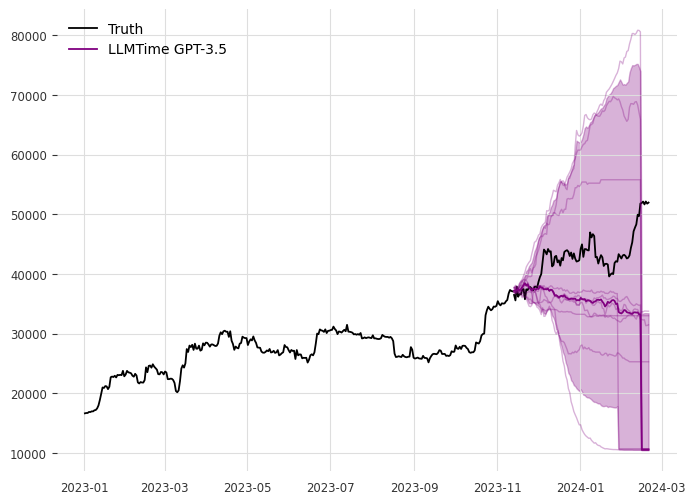

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:22<00:00, 22.34s/it]

<Figure size 640x480 with 0 Axes>

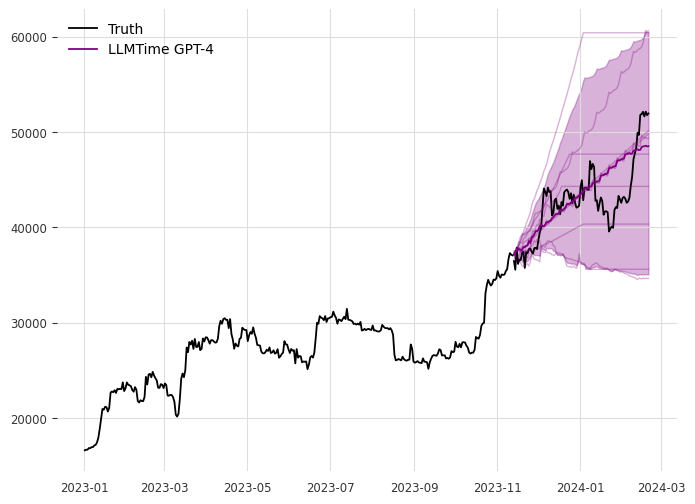

Model :  LLMTime GPT-3.5
Sequence lenght :  316
(' 2 6 0 , 2 6 2 , 2 6 2 , 2 7 0 , 2 6 9 , 2 7 4 , 2 7 4 , 2 8 1 , 2 8 4 , 2 9 5 , 3 1 6 , 3 5 4 , 3 9 9 , 4 4 2 , 4 3 9 , 4 5 2 , 4 5 0 , 4 3 0 , 4 4 7 , 5 1 4 , 5 1 9 , 5 1 6 , 5 2 4 , 5 1 3 , 5 3 1 , 5 2 8 , 5 3 1 , 5 2 9 , 5 5 9 , 5 2 1 , 5 3 3 , 5 5 9 , 5 4 8 , 5 4 6 , 5 4 2 , 5 2 5 , 5 1 8 , 5 3 8 , 5 2 6 , 4 7 7 , 4 7 0 , 4 8 0 , 4 7 7 , 4 7 6 , 4 9 4 , 5 8 4 , 5 5 0 , 5 9 4 , 5 9 6 , 5 8 1 , 6 0 5 , 5 8 9 , 5 7 8 , 5 6 7 , 5 3 6 , 5 3 5 , 5 5 1 , 5 4 9 , 5 3 4 , 5 5 4 , 5 4 7 , 5 0 1 , 5 0 1 , 5 0 4 , 5 0 3 , 4 9 4 , 4 7 4 , 4 1 7 , 4 0 8 , 4 2 1 , 4 8 6 , 5 7 5 , 5 9 8 , 5 8 2 , 6 1 2 , 7 1 2 , 6 9 2 , 7 3 7 , 7 2 6 , 7 4 2 , 7 0 6 , 7 5 0 , 7 1 5 , 7 1 5 , 7 3 7 , 7 0 1 , 7 0 7 , 7 5 2 , 7 3 9 , 7 5 7 , 7 5 7 , 7 4 5 , 7 2 9 , 7 4 5 , 7 4 5 , 7 3 9 , 7 3 4 , 7 3 5 , 7 5 1 , 8 0 7 , 8 3 0 , 8 1 7 , 8 3 8 , 8 4 1 , 8 3 4 , 8 3 5 , 7 9 8 , 8 3 8 , 7 7 1 , 7 4 8 , 7 0 7 , 7 3 0 , 7 2 1 , 7 1 7 , 7 5 0 , 7 5 5 , 8 0 0 , 7 9 3 , 7 9 0

<Figure size 640x480 with 0 Axes>

In [32]:
index = 0
for predict_step in [30,50,100] :
    starting_date = "2023-01-01"
    datasets = get_bitcoin_datasets(predict_steps=predict_step, start_date=starting_date)
    ds_name = 'BTC_Daily_ohlc'

    data = datasets[ds_name]
    train, test = data # or change to your own data
    out = {}
    for model in model_names: # GPT-4 takes a about a minute to run
        model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
        hypers = list(grid_iter(model_hypers[model]))
        num_samples = 10
        pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
        out[model] = pred_dict
        index += 1
        plot_preds(train, test, pred_dict, model, show_samples=True, save_index=index)


    for model in model_names[:-1]: # GPT-4 takes a about a minute to run
        print("Model : ", model)
        string = out[model]['input_strs']
        string = str(string)
        number_comma = 0
        for elt in string :
            # print(elt)
            if elt == ',' :
                number_comma += 1
        print("Sequence lenght : ", number_comma - 1)
        print(string)


    with open(f"datasets/bitcoin/BTC_Daily_ohlc.csv") as f:
        df = pd.read_csv(f, usecols=[0, 4], parse_dates=[0])
        mask = (df["date"] > starting_date) 
        df = df.loc[mask]

        start_date = df["date"].iloc[0]
        end_date = df["date"].iloc[-1]

        print("Data set : BTC_Daily_ohlc")
        print(f"from {start_date} to {end_date}")
        print(f"{df.shape[0]} data points, training on {df.shape[0]- predict_step} and forecasting on {predict_step} points")
        print("Imput is scaled closing price")

        # df['close'] = df['close'].astype(float)
        # series = pd.Series(df['close'].values, index=df['date'])


## Running LLMTime and Visualizing Results ##

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


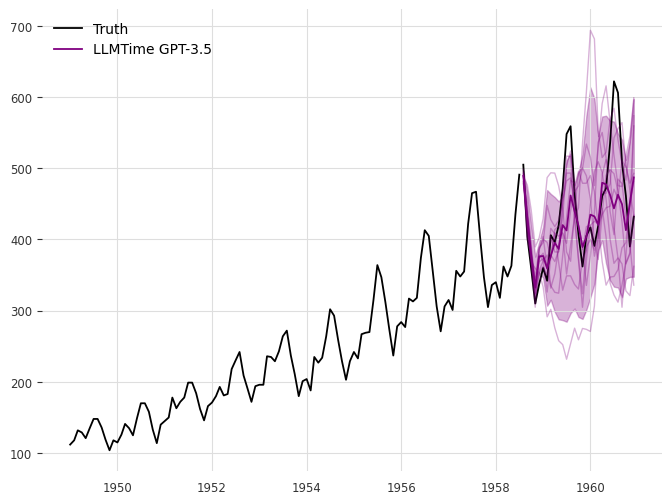

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:05<00:00,  5.39s/it]


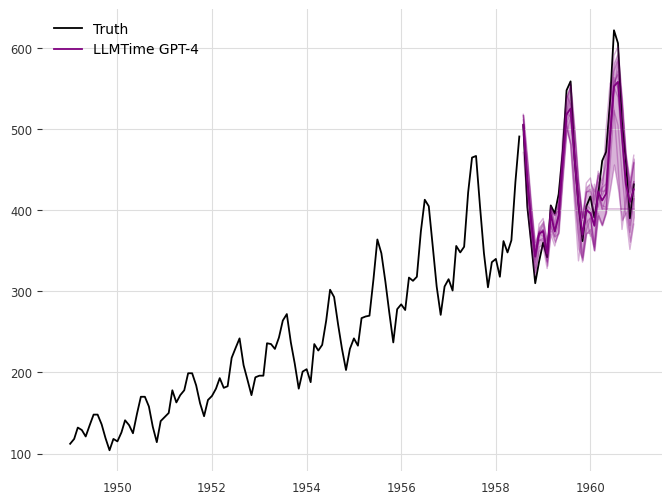

Train length: 86, Val length: 29


Hyperparameter search:   0%|          | 0/4 [00:00<?, ?it/s]/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization

Sampling with best hyper... defaultdict(<class 'dict'>, {'p': 12, 'd': 2, 'q': 0, 'dataset_name': 'AirPassengersDataset'}) 
 with NLL 3.747898


/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


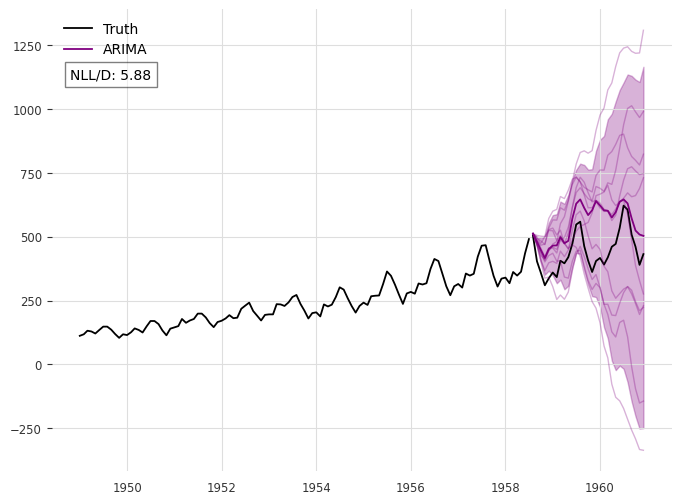

In [16]:
datasets = get_datasets()
ds_name = 'AirPassengersDataset'

data = datasets[ds_name]
train, test = data # or change to your own data
out = {}
for model in model_names: # GPT-4 takes a about a minute to run
    model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
    hypers = list(grid_iter(model_hypers[model]))
    num_samples = 10
    pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
    out[model] = pred_dict
    plot_preds(train, test, pred_dict, model, show_samples=True)